# Logistic Regression
Logistic regression is a statistical classification model used to conduct regression analysis between a binary dependent variable and one or more independent variables. It uses a logistic function to determine the probability of the response (dependent) variable belonging to a certain category. This post uses machine learning to implement logistic regression.

Using weather data, this post first presents a logistic regression between temperature (predictor) and humidity (response). It then presents a logistic regression model using multiple independent variables, temperature and wind speed. The results are then compared with the results from the same model by using sklearn library. The objective of this post is to show the calculations involved in using machine learning to build a logistic regression model. 

If you would like to learn more on machine learning, I will recommend a course on <a href="https://www.coursera.org/learn/machine-learning">machine learning</a> by Andrew Ng on Coursera.

## Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import csv
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
from scipy.special import expit

## Define all required functions

In [162]:
def load_data(filename, rows=10):
    """
    Reads csv file and loads specified columns

    Arguments:
        filename -- full path with filename
        rows -- number of rows to load
    Returns:
        dataframe
    """

    df = pd.read_csv(filename, usecols=["Temperature (C)", "Humidity", "Wind Speed (km/h)"], 
                       na_values=["nan"], nrows=rows)
    return df


def normalize(data):
    """
    Normalizes each column of the data matrix using mean and standard deviation.

    Arguments:
        data -- matrix of data to be normalized
    Returns:
        normalized data matrix
    """
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data -  data_mean) / data_std

def prepare_data(df, x_col, y_col):
    """
    prepare x and y values

    Arguments:
        df -- pandas dataframe
        x_col -- name of x column(s)
        y_col -- name of y column
    Returns:
        x_data -- dataframe for x values
        y_data -- dataframe for y values
    """
    # Dependent variable: humidity
#     y_temp = df.loc[:, y_col]
    y = df.loc[:, y_col]
    
    # Independent variable: Temperature
    x = df.loc[:, x_col]

    # Normalize data
    x_data = normalize(x)

    # Change y into categories for logistic regression
    # Using 0.7 arbitrarily to divide the variable into two groups humid (1) and non-humid (0)
    y_data = pd.Series(np.where(y.values > 0.7, 1, 0))

    return x_data, y_data

def hx(x, theta):
    """
    Calculates sigmoid of X and theta

    Arguments:
        x -- input matrix
        theta -- vector of regression parameters
    Returns:
        sigmoid vector
    """
    return sigmoid(np.dot(x, theta))

def sigmoid(x):
    """
    Calculates sigmoid of X

    Arguments:
        x -- matrix of input values
    Returns:
        sigmoid vector
    """
    return 1 / (1 + np.exp(-x))
    
def loss(theta0, theta1, x, y):
    """
    Calculates loss

    Arguments:
        theta0 -- first parameter of logistic function
        theta1 -- second parameter of logistic function
        x -- input matrix
        y -- labels
    Returns:
        loss value
    """
    n = x.shape[0]
    total_loss = 0
    for i in range(n):
        z = sigmoid(theta0 + theta1*x[i])
        part1 = y[i] * np.log(z)
        part2 = (1 - y[i]) * np.log(1 - z)
        total_loss += part1 + part2

    return -total_loss/n

def loss_vector(theta, x, y, regrate):
    """
    Vectorize the loss calculation and also implementing regularization

    Arguments:
        theta -- vector of regression parameters; dimension (d,1)
        x -- input matrix; dimenstion (n, d)
        y -- labels

    Returns:
        sigmoid vector; dimension (n, 1)
    """    
    m = y.size
    h = hx(x, theta)
    return -((1/m)*(np.dot(y.T, np.log(h)) + np.dot((1-y).T, np.log(1-h))) + 
        (regrate/(2*m))*(np.dot(theta.T, theta)))


def run_model(x, y, num_iter = 1000):
    """
    Run logistic regression. Use gradient descent to find model parameters.

    Arguments:
        x -- input matrix
        y -- labels
        num_iter -- number of times to iterate to find model parameters
    Returns:
        theta0 -- first model parameter
        theta1 -- second model parameter
        loss -- list of loss values
    """
    theta0 = 0
    theta1 = 0
    alpha = 0.000025
    x = np.array(x)
    y = np.array(y)
    
    loss_val = loss(theta0, theta1, x, y)
    n = x.shape[0]
    costs = []
    
    for k in range(num_iter):
        temp0 = 0
        temp1 = 0
        theta0_prev = theta0
        theta1_prev = theta1

        for i in range(n):
            value = (sigmoid(theta0 + theta1 * x[i]) - y[i])
            temp0 += value
            temp1 += value * x[i]

        theta0 -= alpha * temp0
        theta1 -= alpha * temp1
        loss_new = loss(theta0, theta1, x, y)
        costs.append(loss_new)
        
        if k % 100 == 0:
            print (k, theta0, theta1, loss_new)
        
        loss_val = loss_new

    # print value from last iteration
    print (k, theta0, theta1, loss_new)
    
    return theta0, theta1, costs

def run_multi_model(x, y, num_iter = 1000, regrate = 0):
    """
    Run logistic regression. Use gradient descent to find model parameters.

    Arguments:
        x -- input matrix; dimension (n, d)
        y -- labels; dimension (n, 1)
        num_iter -- number of times to iterate to find model parameters
        regrate -- regularization rate
    Returns:
        theta -- model parameter; dimension (d, 1)
        loss -- list of loss values
    """    
    # initialize theta with zeros
    theta = np.zeros((x.shape[1], 1))

    alpha = 0.025
    loss_val = 0
    m = y.shape[0]
    costs = []

    for k in range(num_iter):
        theta_prev = theta

        # calculate loss
        # using .item() to get the value from arrays to plot later 
        loss_new = loss_vector(theta, x, y, regrate).item()
        costs.append(loss_new)
        loss_val = loss_new
        
        # calc gradient descent
        theta = theta - alpha * ((1/m) * np.dot(x.T, (hx(x, theta) - y)) + (regrate / m) * theta)

        if k % 100 == 0:
            print(k, np.ravel(theta), loss_val)
            
    # print value from last iteration
    print(k, np.ravel(theta), loss_val)
    
    return theta, costs

# Step 1: Load data

In [134]:
# load data. The load_data function returns a pandas dataframe object.
df_data = load_data("./data/weatherHistory.csv", rows=1000000)
df_data.dropna()

print(df_data.shape)
print(df_data.head())

(96453, 3)
   Temperature (C)  Humidity  Wind Speed (km/h)
0         9.472222      0.89            14.1197
1         9.355556      0.86            14.2646
2         9.377778      0.89             3.9284
3         8.288889      0.83            14.1036
4         8.755556      0.83            11.0446


# Step 2: Prepare data

In [159]:
x, y = prepare_data(df_data, "Temperature (C)", "Humidity")
print("x: ", x.shape)
print("y: ", y.shape)

x:  (96453,)
y:  (96453,)


# Step 3: Run model
Parameters theta0 and theta1 for logistic regression is determined using gradient descent.

In [163]:
theta0, theta1, costs = run_model(x, y, num_iter = 100)
print()
print("Theta0: {}".format(str(theta0)))
print("Theta1: {}".format(str(theta1)))
print("Loss: {}".format(str(costs[-1])))

0 0.31646250000000004 -0.6381478326898985 0.54322698395065
99 0.7742304680557368 -1.5465095040059285 0.48508546186167434

Theta0: 0.7742304680557368
Theta1: -1.5465095040059285
Loss: 0.48508546186167434


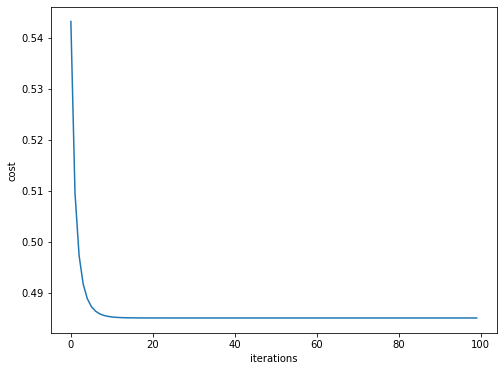

In [164]:
# plot cost 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.show()
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

From the above plot, we can see that the model converges after a few iterations.

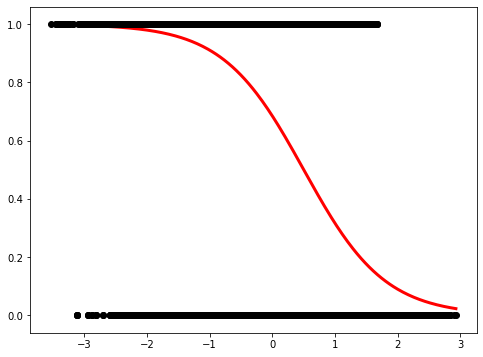

In [165]:
# plot sigmoid function
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(x.ravel(), y, color='black', zorder=20)
X_test = np.linspace(np.min(x), np.max(x), 300)

loss_values = expit(theta0 + X_test * theta1).ravel()

plt.plot(X_test, loss_values, color='red', linewidth=3)


# Logistic regression using sklearn

[0.77418653] [[-1.54633619]]
loss:  [[0.48508546]]


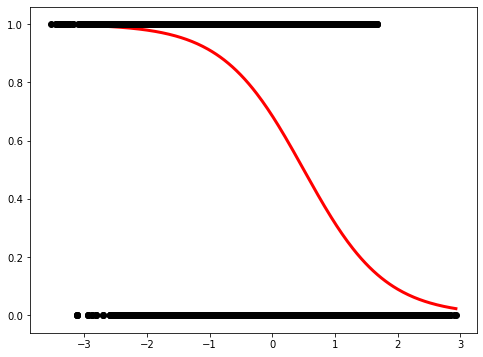

In [138]:
from sklearn.linear_model import LogisticRegression

x, y = prepare_data(df_data, "Temperature (C)", "Humidity")

x1 = np.array(x)
y1 = np.array(y)
x1 = x1.reshape(-1, 1)
y1 = y1.reshape(-1, 1)
y1 = np.ravel(y1)

model = LogisticRegression()
model.fit(x1, y1)
predicted_classes = model.predict(x1)

print(model.intercept_, model.coef_)
# print(model.get_params())
# print(x)
# print(model.predict_proba(x))

# and plot the result
plt.figure(1, figsize=(8, 6))
plt.clf()
plt.scatter(x1.ravel(), y1, color='black', zorder=20)
X_test = np.linspace(np.min(x), np.max(x), 300)

loss_val = expit(model.intercept_ + X_test * model.coef_).ravel()

plt.plot(X_test, loss_val, color='red', linewidth=3)

print("loss: ", loss(model.intercept_, model.coef_, x, y))


## Comparison
The parameter values received from our implementation matches closely with the ones received from sklearn:

<table>
    <tr>
        <td>Parameters</td>
        <td>Ours</td>
        <td>sklearn</td>
    </tr>
    <tr>
        <td>Theta0</td>
        <td>0.77423047</td>
        <td>0.77418653</td>
    </tr>    
    <tr>
        <td>Theta1</td>
        <td>-1.54650950</td>
        <td>-1.54633619</td>
    </tr> 
    <tr>
        <td>Loss</td>
        <td>0.48508546</td>
        <td>0.48508546</td>
    </tr> 

</table>


# Logistic Regression for multiple features

In [169]:
"""
Impelement Logistic Regression for multiple features using vectorization
Vectorization makes the calculation much faster
"""
# prepare x and y data
x, y = prepare_data(df_data, ["Temperature (C)", "Wind Speed (km/h)"], "Humidity")

# # reshape to dimension m, 1
y = np.array(y)
y = y.reshape(-1,1)

#add ones to x array - to help with matrix multiplication
x = np.c_[np.ones(x.shape[0]),x]
print(x.shape)

# Here, regularization is set to zero. You can try other values.
theta, costs = run_multi_model(x, y, num_iter = 3000, regrate = 0)

print()
for i, t in enumerate(theta):
    print("Theta{}: {}".format(str(i), str(t)))

print("Loss: {}".format(str(costs[-1])))

(96453, 3)
0 [ 0.003281   -0.00661615 -0.00232322] 0.6931471805599301
100 [ 0.24900693 -0.50170595 -0.17530695] 0.5539050155597701
200 [ 0.39501983 -0.79535873 -0.27777919] 0.5055396244897639
300 [ 0.49231177 -0.99061891 -0.34654756] 0.4842647998680378
400 [ 0.56202307 -1.13023469 -0.3963067 ] 0.47339896523005875
500 [ 0.61429044 -1.2347273  -0.43396444] 0.46730983601493575
600 [ 0.65467539 -1.31535154 -0.46329349] 0.46368171502297073
700 [ 0.68654228 -1.37890438 -0.48658656] 0.4614254475947469
800 [ 0.71207578 -1.42978904 -0.50534636] 0.4599779786062508
900 [ 0.7327714  -1.4710121  -0.52061303] 0.4590274577844772
1000 [ 0.74969502 -1.50471124 -0.5331363 ] 0.4583919812216999
1100 [ 0.76363061 -1.53245539 -0.54347342] 0.45796112572745773
1200 [ 0.77516935 -1.55542568 -0.55204853] 0.4576657295604602
1300 [ 0.78476612 -1.57452964 -0.55919064] 0.45746138204988873
1400 [ 0.79277671 -1.59047637 -0.56515876] 0.4573189881058248
1500 [ 0.79948314 -1.60382753 -0.57015938] 0.4572191730709678
1600

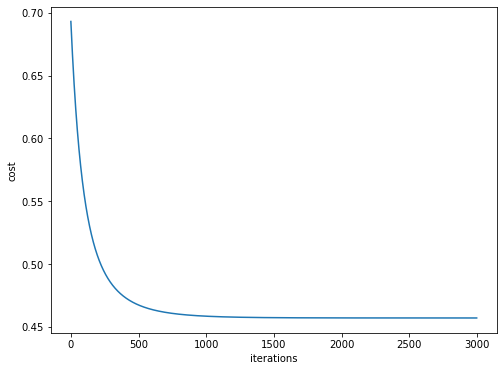

In [170]:
# plot cost 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.show()
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations')
plt.show()

# Logistic Regression for multiple features using sklearn

In [168]:
"""
Impelement Logistic Regression for multiple features using sklearn
"""
# using sklearn
from sklearn.linear_model import LogisticRegression

# prepare x and y data
x, y = prepare_data(df_data, ["Temperature (C)", "Wind Speed (km/h)"], "Humidity")

# normalize data
# x = mean_normalize(x)

# change y to categories
# y = pd.Series(np.where(y.values > 0.7, 1, 0))

model = LogisticRegression()
model.fit(x, y)
# predicted_classes = model.predict(x)

print('Slope:' , model.coef_)
print('Intercept:', model.intercept_)

# create theta array from model parameters
a = model.intercept_
b = model.coef_
b.T.shape
a = a.reshape(-1,1)
theta_estimated = np.concatenate((a, b.T), axis=0)
# print(theta_estimated)

# add ones to x to use loss_vector function
x = np.c_[np.ones(x.shape[0]),x]
print("loss:", loss_vector(theta_estimated, x, y, 0))

Slope: [[-1.67595486 -0.59721129]]
Intercept: [0.83574723]
loss: [[0.45697545]]


## Comparison
The parameter values received from our implementation matches closely with the ones received from sklearn:

<table>
    <tr>
        <td>Parameters</td>
        <td>Ours</td>
        <td>sklearn</td>
    </tr>
    <tr>
        <td>Theta0</td>
        <td>0.83274812</td>
        <td>0.83574723</td>
    </tr>    
    <tr>
        <td>Theta1</td>
        <td>-1.67007388</td>
        <td>-1.67595486</td>
    </tr> 
    <tr>
        <td>Theta2</td>
        <td>-0.59500407</td>
        <td>-0.59721129</td>
    </tr>     
    <tr>
        <td>Loss</td>
        <td>0.45697715</td>
        <td>0.45697545</td>
    </tr> 

</table>


    